In [8]:

# from pathlib import Path
# import zarr

# def find_all_zarr_files():
#     """각 실험 디렉토리의 모든 zarr 파일 찾기"""
#     base_path = Path('./kaggle/input/czii-cryo-et-object-identification/train')
#     experiments = {}
    
#     for exp_dir in base_path.glob("**/VoxelSpacing10.000"):
#         exp_name = exp_dir.parent.name  # 실험 이름 (예: TS_5_4)
#         zarr_files = list(exp_dir.glob("*.zarr"))
        
#         if zarr_files:
#             experiments[exp_name] = {
#                 'path': str(exp_dir),
#                 'files': [f.name for f in zarr_files]
#             }
    
#     return experiments

# def test_all_zarr_files():
#     """모든 실험의 zarr 파일 정보 출력"""
#     experiments = find_all_zarr_files()
    
#     for exp_name, info in experiments.items():
#         print(f"\n실험: {exp_name}")
#         print(f"경로: {info['path']}")
#         print("zarr 파일들:")
#         for zarr_file in info['files']:
#             zarr_path = Path(info['path']) / zarr_file
#             try:
#                 root = zarr.open(str(zarr_path), mode='r')
#                 sample = root[0]
#                 print(f"- {zarr_file}: shape={sample.shape}")
#             except Exception as e:
#                 print(f"- {zarr_file}: 오류 발생 ({str(e)})")

# if __name__ == "__main__":
#     test_all_zarr_files()

In [9]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    NormalizeIntensityd
)

class CryoET_2_5D_Dataset(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 mode: str = 'train',
                 slice_depth: int = 3,
                 crop_size: Tuple[int, int] = (96, 96),
                 transform = None):
        """
        Args:
            data_dir: 데이터셋 기본 경로
            mode: 'train' 또는 'val'
            slice_depth: 중심 기준 슬라이스 수 (항상 홀수)
            crop_size: (height, width) crop 크기
            transform: MONAI transform
        """
        self.data_dir = Path(data_dir) / mode
        self.slice_depth = slice_depth
        self.crop_size = crop_size
        self.transform = transform
        self.pad_size = slice_depth // 2
        
        # 이미지와 라벨 파일 리스트
        self.image_files = sorted(list((self.data_dir / 'images').glob('*.npy')))
        self.label_files = sorted(list((self.data_dir / 'labels').glob('*.npy')))
        
        assert len(self.image_files) == len(self.label_files), "이미지와 라벨 수가 다릅니다"
        
    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx) -> Dict:
        # 이미지와 라벨 로드
        image = np.load(self.image_files[idx])  # (D, H, W)
        label = np.load(self.label_files[idx])  # (D, H, W)
        
        # 원본 shape 저장
        original_shape = image.shape
        
        # 중심 슬라이스 선택
        center_idx = image.shape[0] // 2
        start_idx = center_idx - self.pad_size
        end_idx = center_idx + self.pad_size + 1
        
        # 패딩 처리
        if start_idx < 0 or end_idx > image.shape[0]:
            padded_image = np.pad(
                image,
                ((self.pad_size, self.pad_size), (0, 0), (0, 0)),
                mode='edge'
            )
            start_idx += self.pad_size
            end_idx += self.pad_size
            slices = padded_image[start_idx:end_idx]
        else:
            slices = image[start_idx:end_idx]
        
        # 중심 슬라이스의 라벨만 사용
        center_label = label[center_idx]
        
        # 중앙 crop 좌표 계산
        start_h = (image.shape[1] - self.crop_size[0]) // 2
        start_w = (image.shape[2] - self.crop_size[1]) // 2
        
        # crop 적용
        slices_cropped = slices[:, 
                              start_h:start_h + self.crop_size[0], 
                              start_w:start_w + self.crop_size[1]]
        label_cropped = center_label[start_h:start_h + self.crop_size[0],
                                   start_w:start_w + self.crop_size[1]]
        
        data_dict = {
            'image': np.array(slices_cropped)[None, ...],  # (1, D, H, W)
            'label': np.array(label_cropped)[None, ...],   # (1, H, W)
            'crop_info': {
                'z_start': start_idx,
                'z_center': center_idx,
                'y_start': start_h,
                'x_start': start_w,
                'crop_size': self.crop_size,
                'original_shape': original_shape,
                'file_name': self.image_files[idx].stem
            }
        }
        
        if self.transform:
            data_dict = self.transform(data_dict)
            
        return data_dict

# Transform 설정
train_transforms = Compose([
    EnsureChannelFirstd(
        keys=['image', 'label'],
        channel_dim=0,
        allow_missing_keys=True
    ),
    NormalizeIntensityd(
        keys=['image'],
        allow_missing_keys=True
    )
])

def create_dataloaders(data_dir: str, batch_size: int = 8, crop_size: int =96):
    train_ds = CryoET_2_5D_Dataset(
        data_dir=data_dir,
        mode='train',
        transform=train_transforms,
        slice_depth=3,
        crop_size=(crop_size, crop_size)
    )
    
    val_ds = CryoET_2_5D_Dataset(
        data_dir=data_dir,
        mode='val',
        transform=None,
        slice_depth=3,
        crop_size=(crop_size, crop_size)
    )
    
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader

# 테스트
if __name__ == "__main__":
    data_dir = "./datasets"
    crop_size = 126
    batch_size = 8
    train_loader, val_loader = create_dataloaders(data_dir, batch_size = batch_size, crop_size = crop_size)
    
    # 데이터 확인
    batch = next(iter(train_loader))
    print("이미지 shape:", batch['image'].shape)
    print("라벨 shape:", batch['label'].shape)
    print("Crop 정보:", batch['crop_info'])

이미지 shape: torch.Size([8, 1, 3, 126, 126])
라벨 shape: torch.Size([8, 1, 126, 126])
Crop 정보: {'z_start': tensor([91, 91, 91, 91, 91, 91, 91, 91]), 'z_center': tensor([92, 92, 92, 92, 92, 92, 92, 92]), 'y_start': tensor([252, 252, 252, 252, 252, 252, 252, 252]), 'x_start': tensor([252, 252, 252, 252, 252, 252, 252, 252]), 'crop_size': [tensor([126, 126, 126, 126, 126, 126, 126, 126]), tensor([126, 126, 126, 126, 126, 126, 126, 126])], 'original_shape': [tensor([184, 184, 184, 184, 184, 184, 184, 184]), tensor([630, 630, 630, 630, 630, 630, 630, 630]), tensor([630, 630, 630, 630, 630, 630, 630, 630])], 'file_name': ['denoised_TS_6_4_image', 'denoised_TS_69_2_image', 'denoised_TS_73_6_image', 'ctfdeconvolved_TS_86_3_image', 'isonetcorrected_TS_73_6_image', 'ctfdeconvolved_TS_69_2_image', 'isonetcorrected_TS_86_3_image', 'denoised_TS_5_4_image']}


In [10]:
from CSANet.CSANet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from CSANet.CSANet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from monai.losses import TverskyLoss

# Model Configuration
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 7  # Your number of classes
config_vit.n_skip = 3
vit_patches_size = 16
img_size = vit_patches_size * 4  # Match your patch size
batch_size = 8
# Training setup
num_epochs = 100
lamda = 0.2
lr = 0.001

data_dir = "./datasets"
train_loader, val_loader = create_dataloaders(data_dir, batch_size=batch_size, crop_size=img_size)

# Initialize model
config_vit.patches.grid = (int(img_size / vit_patches_size), int(img_size / vit_patches_size))
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model.cuda()

# Load pretrained weights
model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))

optimizer = optim.AdamW(model.parameters(), lr=lr)


# TverskyLoss 설정
criterion = TverskyLoss(
    alpha=lamda,  # FP에 대한 가중치
    beta=1-lamda,   # FN에 대한 가중치
    include_background=True,
    softmax=True
)

# 체크포인트 저장 디렉토리 설정
checkpoint_base_dir = Path("./model_checkpoints")
checkpoint_dir = checkpoint_base_dir / f"img{img_size}_lr{lr}_lambda{lamda}"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Training loop 수정
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_data in pbar:
            images = batch_data['image'].cuda()
            labels = batch_data['label'].cuda()
            
            # 차원 분리 및 reshape
            # print(images.shape)
            if images.shape[2] == 96:
                images = images.permute(0, 1, 4, 2, 3)
                labels = labels.permute(0, 1, 4, 2, 3)
                # print(images.shape)
            # prev_image, image, next_image = torch.split(images, 1, dim=2)
            center = images.shape[2] // 2
            prev_image = images[:, :, 0:center, :, :]
            image = images[:, :, center:center+1, :, :]
            next_image = images[:, :, center+1:, :, :]
            
            # 필요한 차원 형태로 변환
            prev_image = prev_image.squeeze(2)  # [B, C, H, W]
            image = image.squeeze(2)
            next_image = next_image.squeeze(2)
            
            # 라벨 처리
            #labels = labels[:, :, center:center+1, :, :]
            #labels = labels.squeeze(2)  # [B, 1, H, W]
            labels = labels.squeeze(1)  # [B, H, W]

            optimizer.zero_grad()
            outputs = model(prev_image, image, next_image)

            # 라벨을 long으로 변환하고 one-hot encoding
            labels = labels.long()
            labels_onehot = torch.nn.functional.one_hot(labels, num_classes=config_vit.n_classes)  # [B, H, W, C]
            # 차원 순서 변경: [B, H, W, C] -> [B, C, H, W]
            labels_onehot = labels_onehot.permute(0, 3, 1, 2).float()
            
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Training loop는 그대로 유지

    # Training loop 내부의 validation과 saving 코드 수정
    # Validation
    if (epoch + 1) % 1 == 0:  # Validate every 5 epochs
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', leave=False)
            for val_data in val_loop:
                val_images = val_data['image'].cuda()
                val_labels = val_data['label'].cuda()
                
                # Training과 동일한 방식으로 데이터 처리
                val_prev, val_curr, val_next = torch.split(val_images, 1, dim=2)
                val_prev = val_prev.squeeze(2)
                val_curr = val_curr.squeeze(2)
                val_next = val_next.squeeze(2)
                
                val_labels = val_labels.squeeze(1)
                val_labels = val_labels.long()
                
                val_outputs = model(val_prev, val_curr, val_next)
                
                val_labels_onehot = torch.nn.functional.one_hot(val_labels, num_classes=config_vit.n_classes)
                val_labels_onehot = val_labels_onehot.permute(0, 3, 1, 2).float()
                
                current_loss = criterion(val_outputs, val_labels_onehot).item()
                val_loss += current_loss
                val_loop.set_postfix({'val_loss': current_loss})
        
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        # Best model 저장
        if epoch == 0 or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, checkpoint_dir / 'best_model.pt')
            print(f'Best model saved with validation loss: {best_val_loss/len(val_loader):.4f}')
            
    # 체크포인트 저장
    if (epoch + 1) % 25 == 0:  # Save every 25 epochs        
        with tqdm(total=1, desc=f'Saving checkpoint for epoch {epoch+1}', leave=False) as pbar:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pt')
            pbar.update(1)


load_pretrained: grid-size from 14 to 4


Epoch 1/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.949]


Validation Loss: 0.9581
Best model saved with validation loss: 0.9581


Epoch 2/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.925]


Validation Loss: 0.9575
Best model saved with validation loss: 0.9575


Epoch 3/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.91] 


Validation Loss: 0.9119
Best model saved with validation loss: 0.9119


Epoch 4/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.905]


Validation Loss: 0.9351


Epoch 5/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.88] 


Validation Loss: 0.9174


Epoch 6/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.874]


Validation Loss: 0.8859
Best model saved with validation loss: 0.8859


Epoch 7/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.855]


Validation Loss: 0.8649
Best model saved with validation loss: 0.8649


Epoch 8/100: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it, loss=0.852]


Validation Loss: 0.8612
Best model saved with validation loss: 0.8612


Epoch 9/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.863]


Validation Loss: 0.8504
Best model saved with validation loss: 0.8504


Epoch 10/100: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it, loss=0.823]


Validation Loss: 0.8469
Best model saved with validation loss: 0.8469


Epoch 11/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.826]


Validation Loss: 0.8517


Epoch 12/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.843]


Validation Loss: 0.8352
Best model saved with validation loss: 0.8352


Epoch 13/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.822]


Validation Loss: 0.8152
Best model saved with validation loss: 0.8152


Epoch 14/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.832]


Validation Loss: 0.8165


Epoch 15/100: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it, loss=0.801]


Validation Loss: 0.8189


Epoch 16/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.804]


Validation Loss: 0.8546


Epoch 17/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.82] 


Validation Loss: 0.8389


Epoch 18/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.819]


Validation Loss: 0.7916
Best model saved with validation loss: 0.7916


Epoch 19/100: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it, loss=0.846]


Validation Loss: 0.7724
Best model saved with validation loss: 0.7724


Epoch 20/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.845]


Validation Loss: 0.8487


Epoch 21/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.843]


Validation Loss: 0.8568


Epoch 22/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.826]


Validation Loss: 0.8506


Epoch 23/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.81] 


Validation Loss: 0.8400


Epoch 24/100: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it, loss=0.81] 


Validation Loss: 0.8536


Epoch 25/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.795]


Validation Loss: 0.8589


Epoch 26/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.843]      


Validation Loss: 0.8557


Epoch 27/100: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it, loss=0.826]


Validation Loss: 0.8586


Epoch 28/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.825]


Validation Loss: 0.8642


Epoch 29/100: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it, loss=0.826]


Validation Loss: 0.8626


Epoch 30/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.826]


Validation Loss: 0.8602


Epoch 31/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.808]


Validation Loss: 0.8592


Epoch 32/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.794]


Validation Loss: 0.8610


Epoch 33/100: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it, loss=0.826]


Validation Loss: 0.8645


Epoch 34/100: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it, loss=0.827]


Validation Loss: 0.8616


Epoch 35/100: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it, loss=0.826]


Validation Loss: 0.8527


Epoch 36/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.825]


Validation Loss: 0.8432


Epoch 37/100: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it, loss=0.826]


Validation Loss: 0.8384


Epoch 38/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.81] 


Validation Loss: 0.8231


Epoch 39/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.825]


Validation Loss: 0.8501


Epoch 40/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.795]


Validation Loss: 0.8613


Epoch 41/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.808]


Validation Loss: 0.8627


Epoch 42/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.809]


Validation Loss: 0.8606


Epoch 43/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.808]


Validation Loss: 0.8620


Epoch 44/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.807]


Validation Loss: 0.8624


Epoch 45/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.807]


Validation Loss: 0.8623


Epoch 46/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.824]


Validation Loss: 0.8644


Epoch 47/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.808]


Validation Loss: 0.8648


Epoch 48/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.823]


Validation Loss: 0.8641


Epoch 49/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.825]


Validation Loss: 0.8636


Epoch 50/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.777]


Validation Loss: 0.8627


Epoch 51/100: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it, loss=0.79]       


Validation Loss: 0.8592


Epoch 52/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.841]


Validation Loss: 0.8485


Epoch 53/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.858]


Validation Loss: 0.8563


Epoch 54/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.807]


Validation Loss: 0.8617


Epoch 55/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.807]


Validation Loss: 0.8620


Epoch 56/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.808]


Validation Loss: 0.8618


Epoch 57/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.841]


Validation Loss: 0.8627


Epoch 58/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.807]


Validation Loss: 0.8630


Epoch 59/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.806]


Validation Loss: 0.8612


Epoch 60/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.823]


Validation Loss: 0.8499


Epoch 61/100: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it, loss=0.806]


Validation Loss: 0.8452


Epoch 62/100: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it, loss=0.807]


Validation Loss: 0.8489


Epoch 63/100: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it, loss=0.807]


Validation Loss: 0.8536


Epoch 64/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.824]


Validation Loss: 0.8593


Epoch 65/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.791]


Validation Loss: 0.8611


Epoch 66/100: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it, loss=0.791]


Validation Loss: 0.8612


Epoch 67/100: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it, loss=0.807]


Validation Loss: 0.8596


Epoch 68/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.793]


Validation Loss: 0.8595


Epoch 69/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.807]


Validation Loss: 0.8568


Epoch 70/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.824]


Validation Loss: 0.8440


Epoch 71/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.823]


Validation Loss: 0.8396


Epoch 72/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.823]


Validation Loss: 0.8378


Epoch 73/100: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it, loss=0.807]


Validation Loss: 0.8493


Epoch 74/100: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it, loss=0.808]


Validation Loss: 0.8621


Epoch 75/100: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it, loss=0.791]


Validation Loss: 0.8638


Epoch 76/100: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it, loss=0.841]      


Validation Loss: 0.8611


Epoch 77/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.841]


Validation Loss: 0.8575


Epoch 78/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.807]


Validation Loss: 0.8578


Epoch 79/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.79] 


Validation Loss: 0.8624


Epoch 80/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.789]


Validation Loss: 0.8637


Epoch 81/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.823]


Validation Loss: 0.8627


Epoch 82/100: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it, loss=0.824]


Validation Loss: 0.8617


Epoch 83/100: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, loss=0.806]


Validation Loss: 0.8633


Epoch 84/100: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it, loss=0.806]


Validation Loss: 0.8633


Epoch 85/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.823]


Validation Loss: 0.8630


Epoch 86/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.806]


Validation Loss: 0.8626


Epoch 87/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.772]


Validation Loss: 0.8624


Epoch 88/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.823]


Validation Loss: 0.8621


Epoch 89/100: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it, loss=0.823]


Validation Loss: 0.8628


Epoch 90/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.806]


Validation Loss: 0.8629


Epoch 91/100: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, loss=0.84] 


Validation Loss: 0.8649


Epoch 92/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.825]


Validation Loss: 0.8617


Epoch 93/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.79] 


Validation Loss: 0.8589


Epoch 94/100: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it, loss=0.84] 


Validation Loss: 0.8564


Epoch 95/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.806]


Validation Loss: 0.8549


Epoch 96/100: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, loss=0.824]


Validation Loss: 0.8573


Epoch 97/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.806]


Validation Loss: 0.8595


Epoch 98/100: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it, loss=0.824]


Validation Loss: 0.8598


Epoch 99/100: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it, loss=0.807]


Validation Loss: 0.8605


Epoch 100/100: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it, loss=0.809]


Validation Loss: 0.8618


In [11]:
from pathlib import Path
import numpy as np
import torch
from scipy import ndimage
from typing import List, Dict, Tuple
from tqdm import tqdm

def get_center_points(label_map: np.ndarray, crop_info: Dict, exclude_class: int = 1) -> List[Dict]:
    """객체 중심점 추출 (class 1 제외)"""
    centers = []
    
    for class_id in np.unique(label_map):
        # class 1 제외
        if class_id == 0 or class_id == exclude_class:
            continue
            
        # 현재 클래스에 대한 바이너리 마스크
        class_mask = label_map == class_id
        labeled_array, num_features = ndimage.label(class_mask)
        
        # 각 객체의 중심점 계산
        for label_id in range(1, num_features + 1):
            object_mask = labeled_array == label_id
            coords = np.array(np.nonzero(object_mask))  # [num_dims, N]
            
            if coords.size > 0:
                # 3D 데이터의 경우 3개의 좌표가 있을 수 있으므로 차원 확인
                if coords.shape[0] == 2:  # 2D case
                    y, x = coords.mean(axis=1)
                else:  # 3D case or other
                    coord_means = coords.mean(axis=1)
                    y, x = coord_means[-2:]  # 마지막 두 차원을 y, x로 사용
                
                # crop 좌표를 원본 좌표로 변환
                orig_x = x + crop_info['x_start']
                orig_y = y + crop_info['y_start']
                orig_z = crop_info['z_center']
                
                centers.append({
                    'x': float(orig_x),
                    'y': float(orig_y),
                    'z': float(orig_z),
                    'class': int(class_id)
                })
    
    return centers

def calculate_distance(point1: Dict, point2: Dict) -> float:
    """두 점 사이의 유클리드 거리"""
    return np.sqrt(
        (point1['x'] - point2['x'])**2 + 
        (point1['y'] - point2['y'])**2 + 
        (point1['z'] - point2['z'])**2
    )

def calculate_fbeta_score(pred_centers: List[Dict], 
                         gt_centers: List[Dict], 
                         distance_threshold: float = 10.0,
                         beta: float = 4.0) -> float:
    """F-beta score 계산 (beta=4)"""
    if len(pred_centers) == 0 and len(gt_centers) == 0:
        return 1.0
    if len(pred_centers) == 0 or len(gt_centers) == 0:
        return 0.0
    
    # 거리 행렬 계산
    distances = np.zeros((len(pred_centers), len(gt_centers)))
    for i, pred in enumerate(pred_centers):
        for j, gt in enumerate(gt_centers):
            # 같은 클래스인 경우에만 매칭
            if pred['class'] == gt['class']:
                distances[i, j] = calculate_distance(pred, gt)
            else:
                distances[i, j] = float('inf')
    
    # 매칭 및 점수 계산
    true_positives = 0
    matched_gt = set()
    
    for i in range(len(pred_centers)):
        if np.min(distances[i]) > distance_threshold:
            continue
            
        min_dist_idx = np.argmin(distances[i])
        if min_dist_idx not in matched_gt:
            true_positives += 1
            matched_gt.add(min_dist_idx)
    
    precision = true_positives / len(pred_centers) if len(pred_centers) > 0 else 0
    recall = true_positives / len(gt_centers) if len(gt_centers) > 0 else 0
    
    # F-beta 계산
    beta_square = beta ** 2
    if precision == 0 and recall == 0:
        return 0.0
    fbeta = (1 + beta_square) * (precision * recall) / (beta_square * precision + recall)
    
    return fbeta

def test_segmentation(model, test_loader, device, config_vit):
    """테스트 및 평가"""
    model.eval()
    results = []
    total_score = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            crop_info = batch['crop_info']
            
            # crop_info 디버깅
            print("Crop info keys:", crop_info.keys())
            for k, v in crop_info.items():
                print(f"{k}: type={type(v)}, shape/len={v.shape if torch.is_tensor(v) else len(v) if hasattr(v, '__len__') else 'scalar'}")
            
            # 2.5D 입력 준비
            prev_image = images[:, :, 0:1, :, :].squeeze(2)
            curr_image = images[:, :, 1:2, :, :].squeeze(2)
            next_image = images[:, :, 2:3, :, :].squeeze(2)
            
            # 추론
            outputs = model(prev_image, curr_image, next_image)
            pred = torch.argmax(outputs, dim=1)  # (B, H, W)
            
            # 배치의 각 샘플에 대해 처리
            for i in range(pred.size(0)):
                try:
                    # crop_info 처리
                    batch_crop_info = {}
                    for k, v in crop_info.items():
                        if torch.is_tensor(v):
                            batch_crop_info[k] = v[i].item()
                        elif isinstance(v, (list, tuple)) and len(v) > i:
                            batch_crop_info[k] = v[i]
                        else:
                            batch_crop_info[k] = v
                    
                    # 예측 및 정답 라벨에서 중심점 추출
                    pred_centers = get_center_points(
                        pred[i].cpu().numpy(), 
                        batch_crop_info
                    )
                    gt_centers = get_center_points(
                        labels[i].cpu().numpy(),
                        batch_crop_info
                    )
                    
                    # F-beta score 계산
                    score = calculate_fbeta_score(pred_centers, gt_centers, beta=4.0)
                    
                    results.append({
                        'file_name': batch_crop_info.get('file_name', f'sample_{num_samples}'),
                        'pred_centers': pred_centers,
                        'gt_centers': gt_centers,
                        'score': score
                    })
                    
                    total_score += score
                    num_samples += 1
                    
                except Exception as e:
                    print(f"Error processing sample {i}: {str(e)}")
                    continue
    
    avg_score = total_score / num_samples if num_samples > 0 else 0
    print(f"\n평균 F4-score: {avg_score:.4f}")
    
    return results

def load_best_model(model, checkpoint_dir: str = "./model_checkpoints"):
    """베스트 모델 가중치 로드"""
    checkpoint_path = Path(checkpoint_dir) / 'best_model.pt'  # .pth에서 .pt로 변경
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"베스트 모델을 찾을 수 없습니다: {checkpoint_path}")
    
    print(f"베스트 모델 로드 중: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.cuda()
    model.eval()
    
    return model

# 사용 예시
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model = load_best_model(model, checkpoint_dir=checkpoint_dir)

# 테스트 실행
if __name__ == "__main__":
    test_loader = val_loader  # val_loader를 test_loader로 사용
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 결과 디렉토리 생성
    save_dir = Path("./test_results")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # 테스트 실행 및 결과 저장
    results = test_segmentation(model, test_loader, device, config_vit)
    np.save(save_dir / "test_results.npy", results)

베스트 모델 로드 중: model_checkpoints\img64_lr0.001_lambda0.2\best_model.pt


C:\Users\pook0\AppData\Local\Temp\ipykernel_2240\3418544050.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
Testing:

Crop info keys: dict_keys(['z_start', 'z_center', 'y_start', 'x_start', 'crop_size', 'original_shape', 'file_name'])
z_start: type=<class 'torch.Tensor'>, shape/len=torch.Size([4])
z_center: type=<class 'torch.Tensor'>, shape/len=torch.Size([4])
y_start: type=<class 'torch.Tensor'>, shape/len=torch.Size([4])
x_start: type=<class 'torch.Tensor'>, shape/len=torch.Size([4])
crop_size: type=<class 'list'>, shape/len=2
original_shape: type=<class 'list'>, shape/len=3
file_name: type=<class 'list'>, shape/len=4


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


평균 F4-score: 0.9444


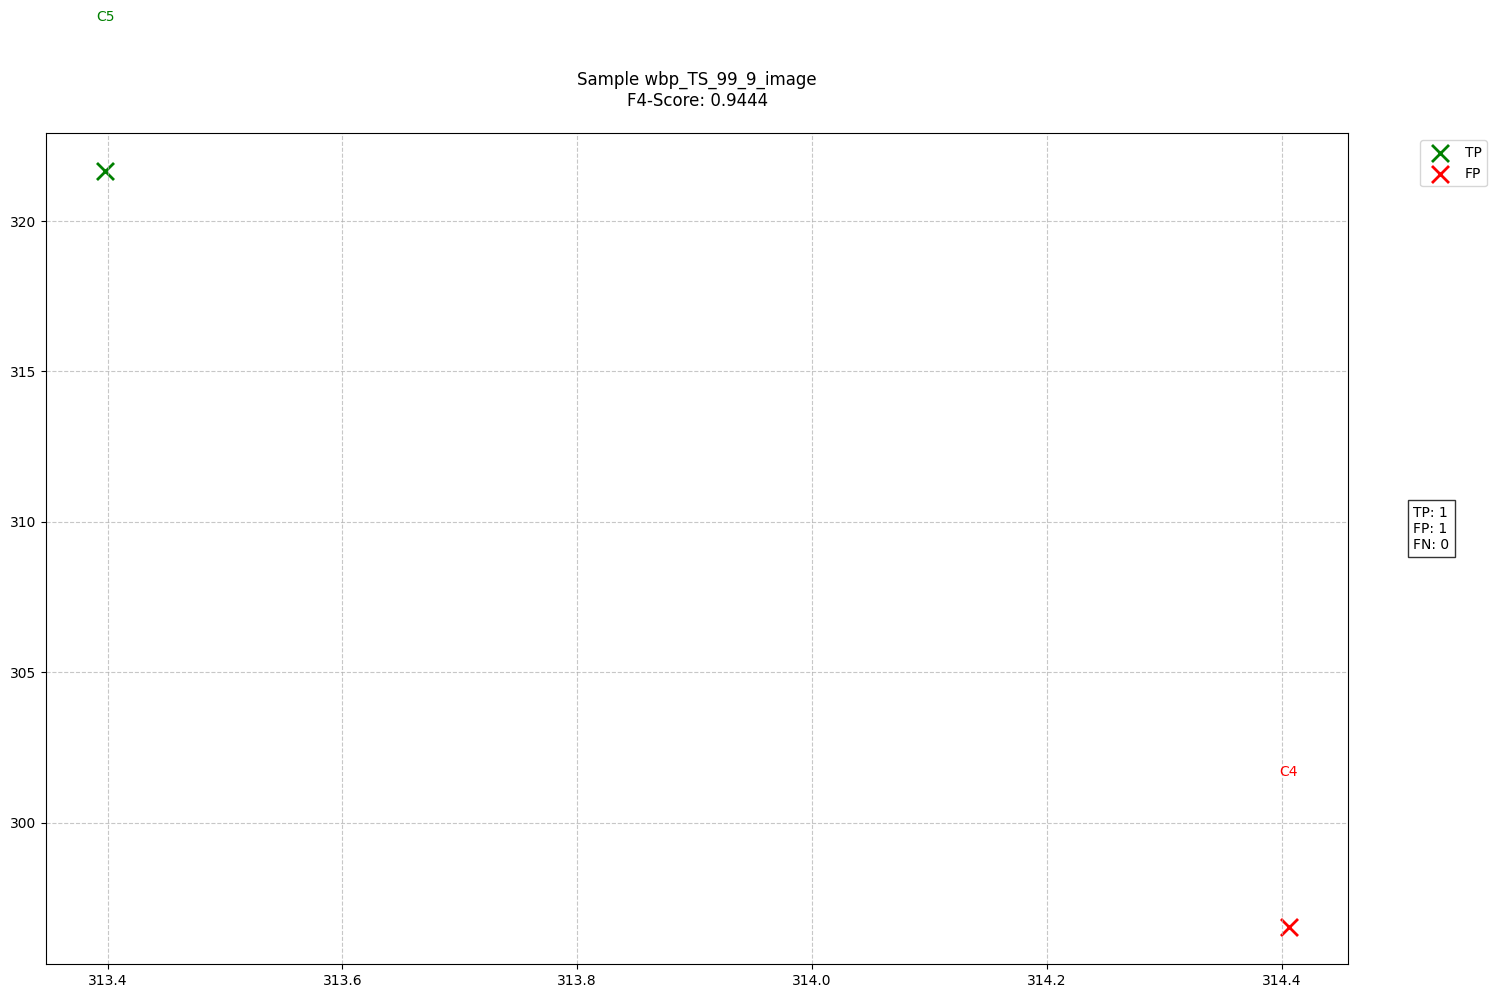

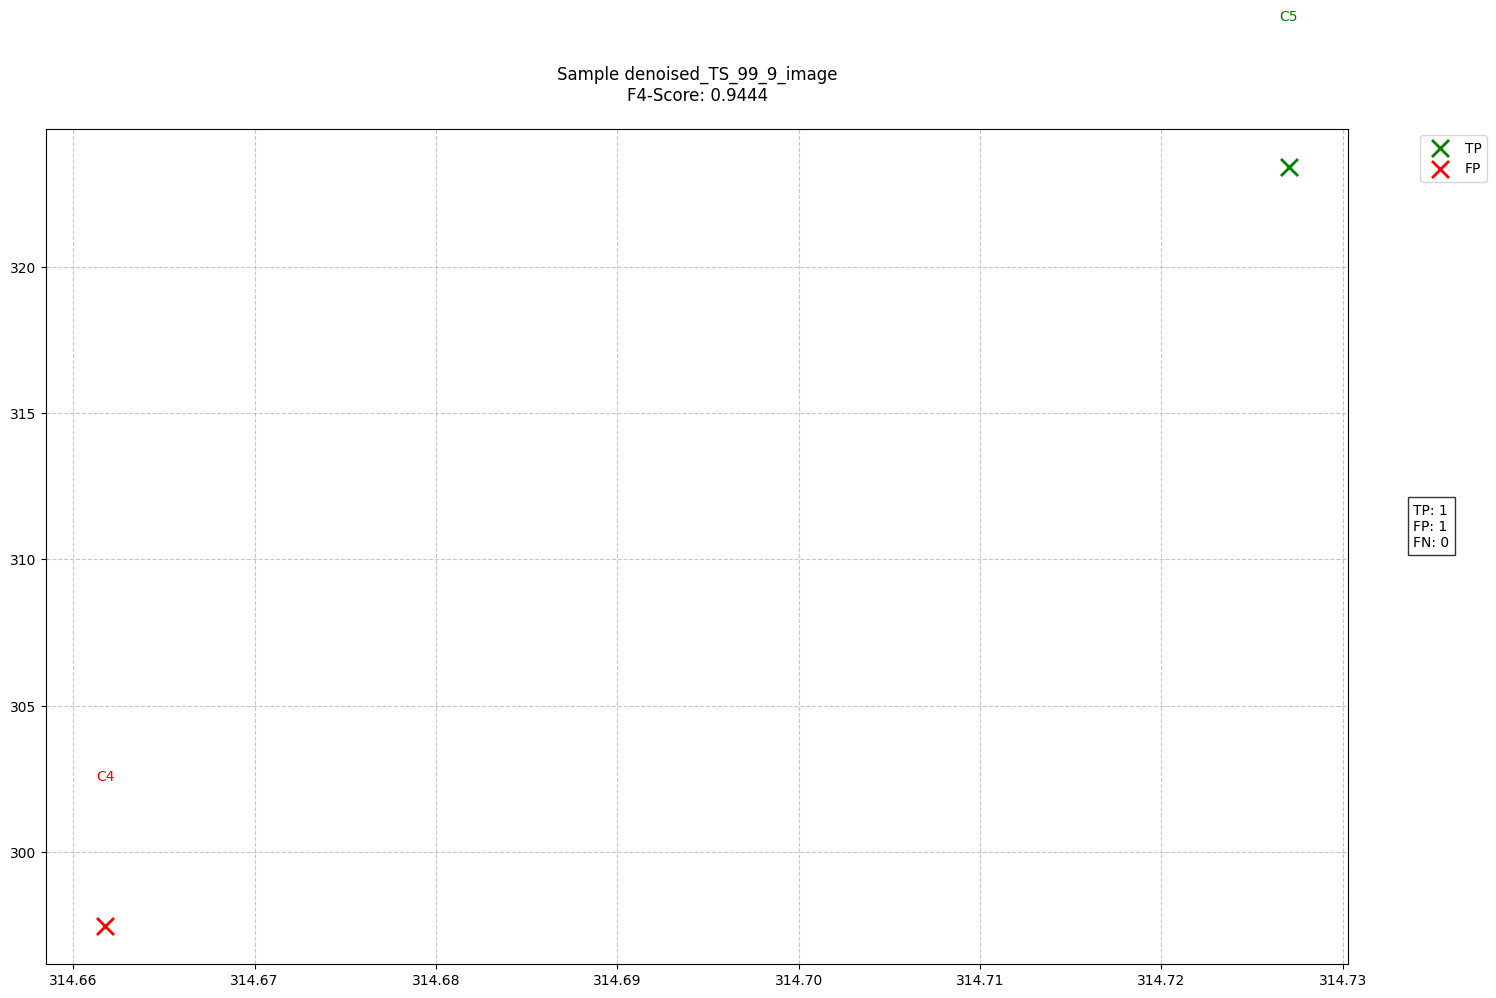

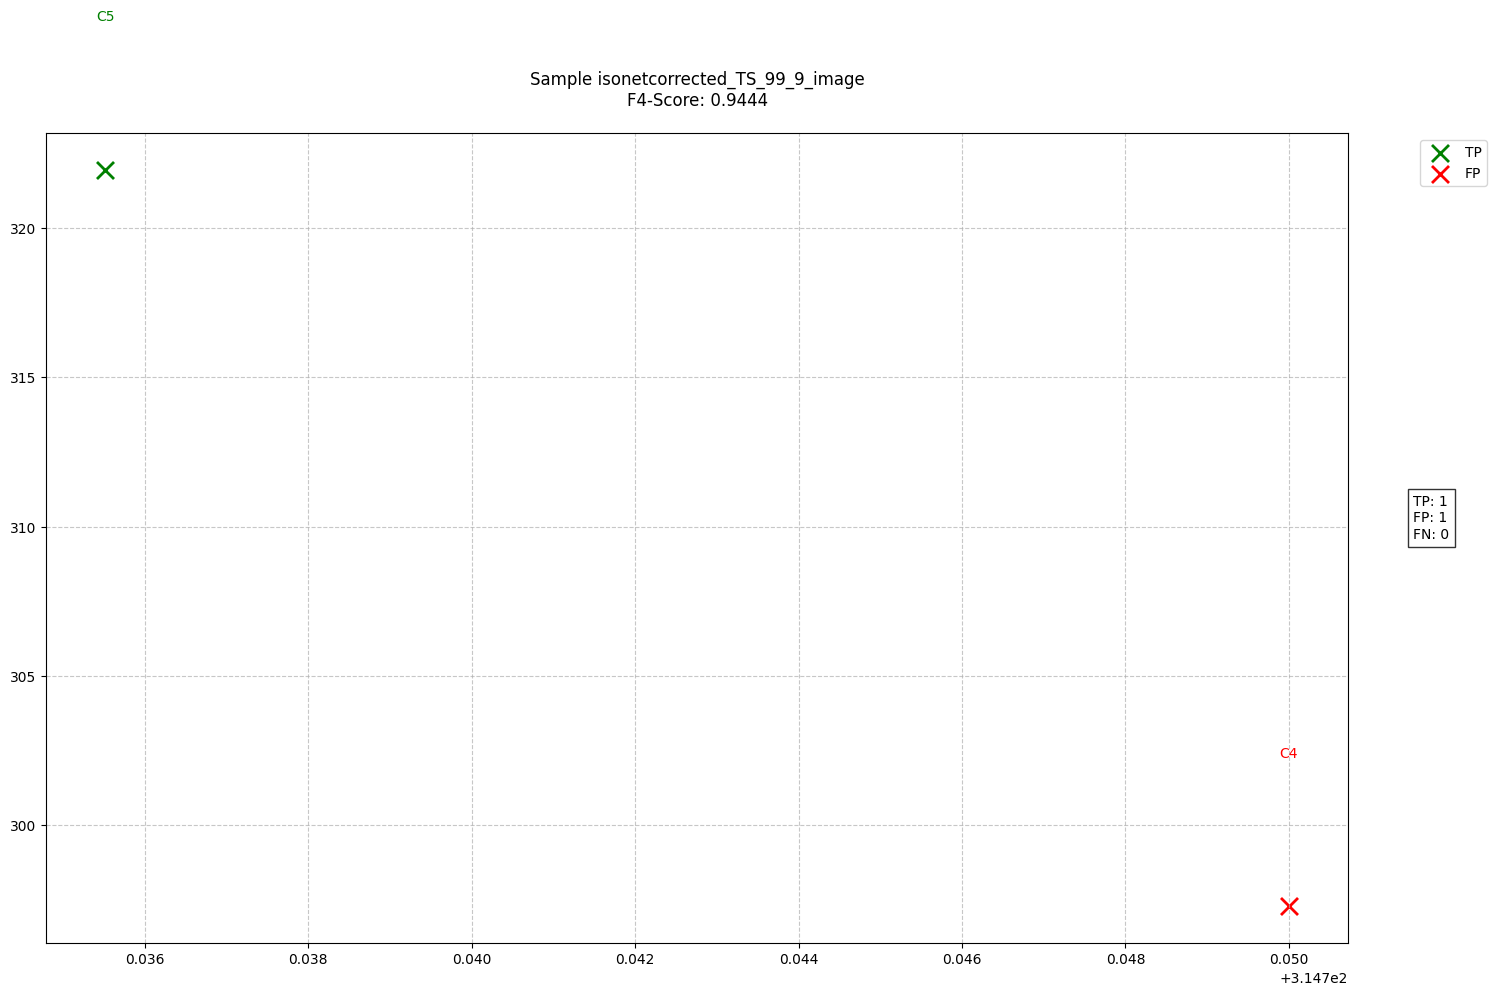

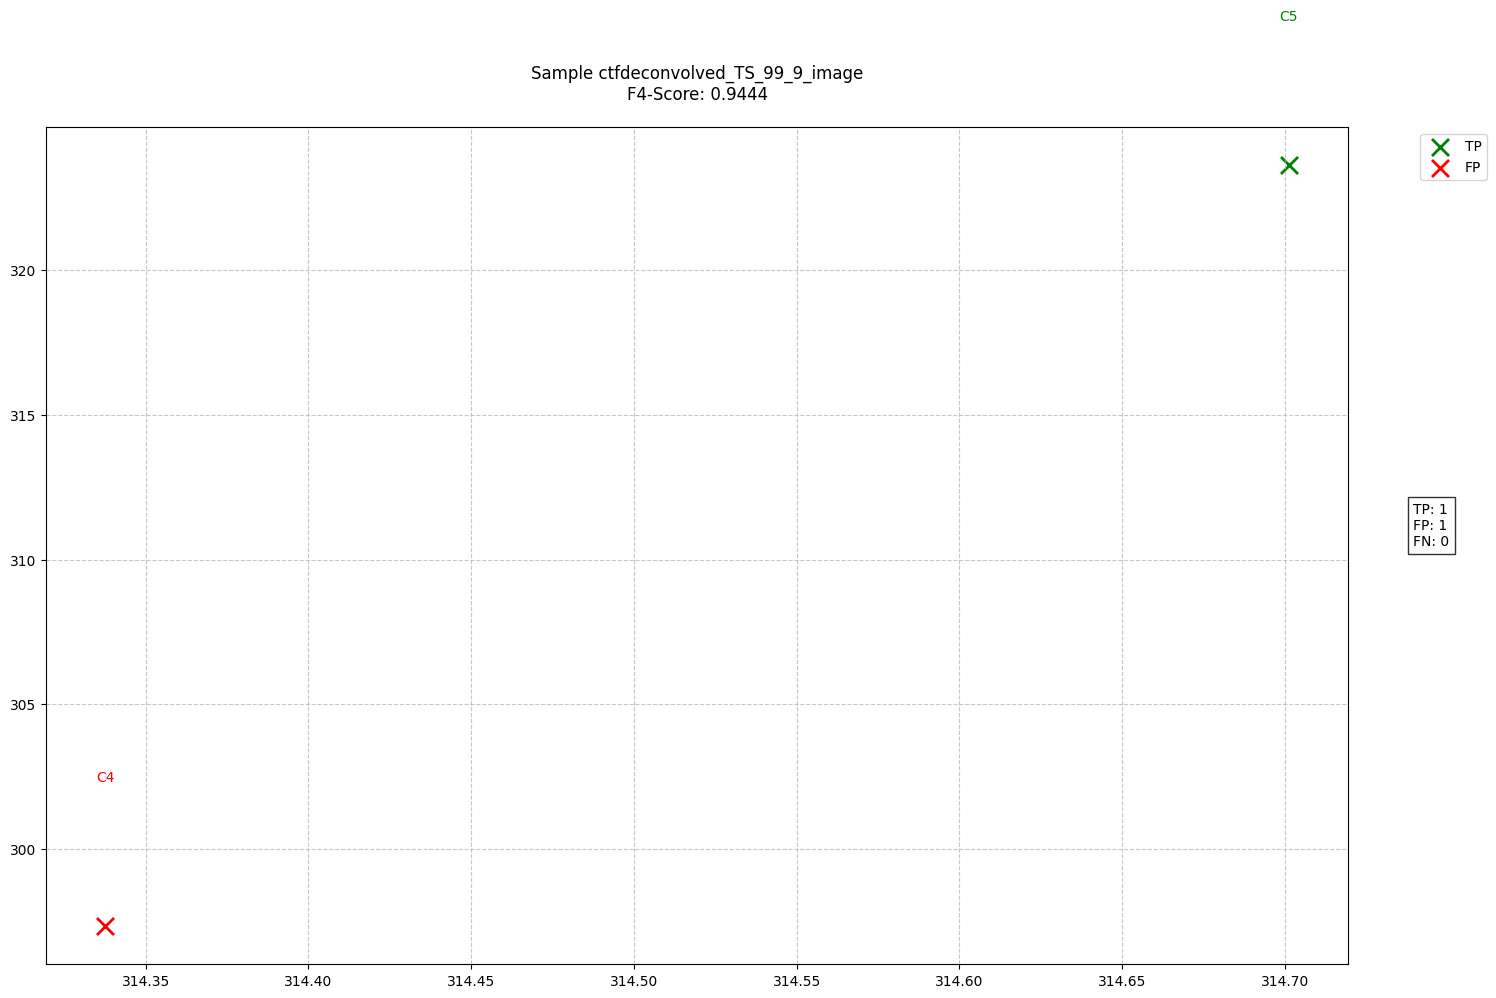


=== 결과 통계 ===
평균 F4-score: 0.9444
최대 F4-score: 0.9444
최소 F4-score: 0.9444


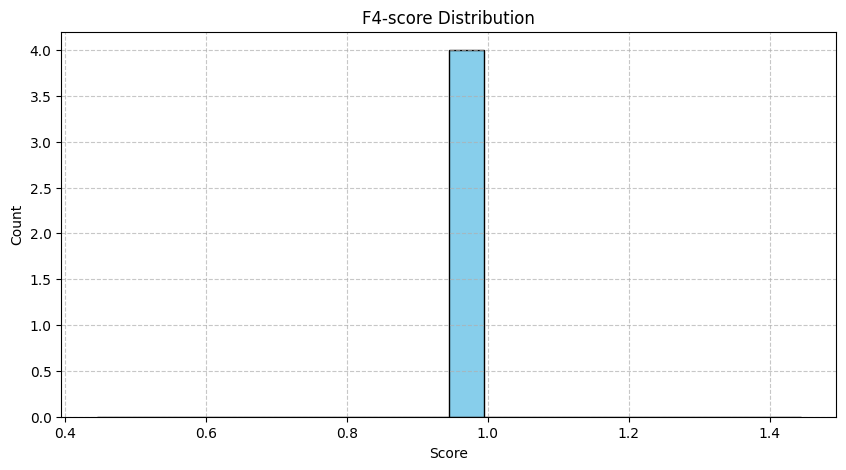

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch

def categorize_predictions(pred_centers, gt_centers, distance_threshold=10.0):
    """예측을 TP, FP, FN으로 분류"""
    tp_pred = []
    fp_pred = []
    fn_gt = gt_centers.copy()
    
    # TP와 FP 찾기
    for pred in pred_centers:
        matched = False
        for gt in gt_centers:
            if pred['class'] == gt['class']:
                dist = np.sqrt(
                    (pred['x'] - gt['x'])**2 + 
                    (pred['y'] - gt['y'])**2 + 
                    (pred['z'] - gt['z'])**2
                )
                if dist <= distance_threshold:
                    tp_pred.append(pred)
                    fn_gt.remove(gt)  # matched GT 제거
                    matched = True
                    break
        if not matched:
            fp_pred.append(pred)
            
    return tp_pred, fp_pred, fn_gt

def visualize_results(results_path: str = "./test_results/test_results.npy", num_samples: int = 5):
    """테스트 결과 시각화"""
    results = np.load(results_path, allow_pickle=True)
    indices = np.random.choice(len(results), min(num_samples, len(results)), replace=False)
    
    for idx in indices:
        result = results[idx]
        
        # TP, FP, FN 분류
        tp_pred, fp_pred, fn_gt = categorize_predictions(
            result['pred_centers'], 
            result['gt_centers']
        )
        
        # 그림 설정
        plt.figure(figsize=(15, 10))
        
        # 결과 시각화
        plt.title(f"Sample {result['file_name']}\nF4-Score: {result['score']:.4f}", pad=20)
        
        # True Positives (녹색 X)
        for center in tp_pred:
            plt.scatter(center['x'], center['y'], c='g', marker='x', s=150, 
                       label='TP' if center == tp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='g', fontsize=10, ha='center')
        
        # False Positives (빨간색 X)
        for center in fp_pred:
            plt.scatter(center['x'], center['y'], c='r', marker='x', s=150, 
                       label='FP' if center == fp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='r', fontsize=10, ha='center')
        
        # False Negatives (파란색 원)
        for center in fn_gt:
            plt.scatter(center['x'], center['y'], c='b', marker='o', s=150, 
                       label='FN' if center == fn_gt[0] else "", facecolors='none', linewidth=2)
            plt.text(center['x'], center['y']-10, f"C{center['class']}", 
                    color='b', fontsize=10, ha='center')
        
        # 범례 및 그리드
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 통계 텍스트 추가
        stats_text = f"TP: {len(tp_pred)}\nFP: {len(fp_pred)}\nFN: {len(fn_gt)}"
        plt.text(1.05, 0.5, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # 전체 통계
    scores = [r['score'] for r in results]
    print(f"\n=== 결과 통계 ===")
    print(f"평균 F4-score: {np.mean(scores):.4f}")
    print(f"최대 F4-score: {np.max(scores):.4f}")
    print(f"최소 F4-score: {np.min(scores):.4f}")
    
    # Score 분포 히스토그램
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("F4-score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    visualize_results()